In [1]:
!pip install rdkit

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.6/27.6 MB 6.6 MB/s eta 0:00:0000:0100:01


In [72]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from sklearn.preprocessing import FunctionTransformer

### Идея: там, где значения повторяются, посчитать среднее отклонение std и расширить датасет путём создания из каждой строчки еще две строки: target, target + std, target - std

In [73]:
df = pd.read_excel('/Users/maria/Documents/ML6sem/Project Хим Задача/19_35000.xlsx').drop(['Unnamed: 0', 'Title'], axis = 1)
df = df.drop_duplicates()
df

,IC50,SMILES
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...
36372,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...
36373,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O
36374,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...
36375,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O


# Распределение таргета, убираем выбросы

{'whiskers': [<matplotlib.lines.Line2D at 0x560a5f050>,
 'caps': [<matplotlib.lines.Line2D at 0x560a3f8d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x560a56c10>],
 'medians': [<matplotlib.lines.Line2D at 0x560a3fad0>],
 'fliers': [<matplotlib.lines.Line2D at 0x560a3ec50>],
 'means': []}

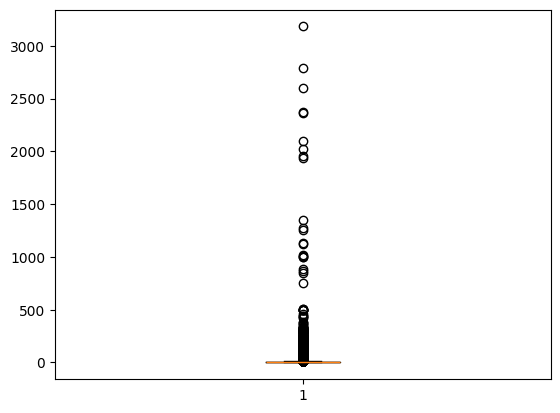

In [74]:
import matplotlib.pyplot as plt

plt.boxplot(df['IC50'])

In [75]:
bolshaya_granitsa_yashik_s_ysami = df['IC50'].quantile(0.75) + (df['IC50'].quantile(0.75) - df['IC50'].quantile(0.25)) * 1.5
bolshaya_granitsa_yashik_s_ysami

12.288499999999999

In [76]:
df = df[df['IC50'] < bolshaya_granitsa_yashik_s_ysami]
df

,IC50,SMILES
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...
34742,12.221000,c1cc(Cl)c(Cl)cc1C(=O)N(CCC2=O)CCN2[C@@H](Cc3cc...
34743,12.242000,c1cc(O)c(O)cc1\C=C\C(=O)N[C@H](C(=O)O)Cc2ccccc2
34744,12.261000,O=c1c(O)coc(C)c1C(=O)Nc2ccccc2
34745,12.283000,c1cccc2[nH]c(c3c12)[C@@H](c4ccccc4)N5[C@@H](C3...


## Стандартное отклонение у таргета, который остался после удаления выбросов

In [77]:
t = df.groupby('SMILES', as_index = False).count().sort_values(by = 'IC50', ascending = False)
tt = df.merge(t, on = 'SMILES')
tt[tt['IC50_y'] > 1]['IC50_x'].std()

2.9981534510922447

### Оставляем только те строки, где нет повторений или std отклонений не больше 20

In [78]:
t = df.groupby('SMILES', as_index = False).count().sort_values(by = 'IC50', ascending = False) 
ic50, smiles = [], []
for i in t[t['IC50'] > 1]['SMILES']:
    if round(df[df['SMILES'] == i]['IC50'].std(), 3) < 20:
        smiles += [i]
        ic50 += [df[df['SMILES'] == i]['IC50'].median()]

df = df.merge(t[t['IC50'] == 1]['SMILES'], on = 'SMILES')
df = pd.concat((df, pd.DataFrame({'IC50': ic50, 'SMILES': smiles})))
df

,IC50,SMILES
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...
34,2.450000,CC(C)c(cc1)cc(c1[C@@]23C)CC[C@@H]2[C@](C)(CN)CCC3
35,0.740500,OCCNCCNc1ccc(NCCNCCO)c(c12)C(=O)c3c(C2=O)c(O)c...
36,0.003695,CCN(CC)C(=O)[C@@H](NC(=O)C)[C@H]([C@H](C1)N=C(...
37,6.156000,Cc1ccc(cc1)S(=O)(=O)N[C@@H](c2ccccc2)C(=O)Oc(c...


In [79]:
df.to_excel('without_dublicates.xlsx', index = False) # На всякий случай сохраняем изменения и сразу же подгружаем их

In [80]:
df = pd.read_excel('without_dublicates.xlsx')
df

,IC50,SMILES
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...
34687,2.450000,CC(C)c(cc1)cc(c1[C@@]23C)CC[C@@H]2[C@](C)(CN)CCC3
34688,0.740500,OCCNCCNc1ccc(NCCNCCO)c(c12)C(=O)c3c(C2=O)c(O)c...
34689,0.003695,CCN(CC)C(=O)[C@@H](NC(=O)C)[C@H]([C@H](C1)N=C(...
34690,6.156000,Cc1ccc(cc1)S(=O)(=O)N[C@@H](c2ccccc2)C(=O)Oc(c...


## Расширяем датасет

In [15]:
df1 = df.copy()
df1['IC50'] = df1['IC50'] + 3
df2 = df.copy()
df2['IC50'] = df2['IC50'] - 3
df = pd.concat((df, df1, df2))
df = df[df['IC50'] >= 0]
df

,IC50,SMILES
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...
34668,1.900000,CC1(C)[C@@H](CC2)CC(\[C@]12C)=N/CCCCCCC\N=C(\[...
34669,0.400000,C[C@]12C(C)(C)[C@@H](CC2)C[C@H]1OC(=O)CCN3CCOCC3
34680,5.600000,s1c(Br)ccc1[C@@H](C[C@@]2(C)O)O[C@@H]([C@H]23)...
34685,1.100000,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N/CCCCCC\N=C(\[C...


# Дескрипторы

In [82]:
def mol_dsc_calc(mols):
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in mols)

# список конституционных и физико-химических дескрипторов из библиотеки RDKit
descriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
               "NHOHCount": Descriptors.NHOHCount,
               "NOCount": Descriptors.NOCount,
               "NumHAcceptors": Descriptors.NumHAcceptors,
               "NumHDonors": Descriptors.NumHDonors,
               "NumHeteroatoms": Descriptors.NumHeteroatoms,
               "NumRotatableBonds": Descriptors.NumRotatableBonds,
               "NumValenceElectrons": Descriptors.NumValenceElectrons,
               "NumAromaticRings": Descriptors.NumAromaticRings,
               "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
               "RingCount": Descriptors.RingCount,
               "MW": Descriptors.MolWt,
               "LogP": Descriptors.MolLogP,
               "MR": Descriptors.MolMR,
               "TPSA": Descriptors.TPSA,
               "NumAliphaticRings": Descriptors.NumAliphaticRings,
               "NumAromaticHeterocycles": Descriptors.NumAromaticHeterocycles,
               "NumSaturatedRings": Descriptors.NumSaturatedRings,
               "NumAromaticCarbocycles": Descriptors.NumAromaticCarbocycles,
               "FractionCSP3": Descriptors.FractionCSP3,
               "MaxAbsPartialCharge": Descriptors.MaxAbsPartialCharge,
               "MinAbsPartialCharge": Descriptors.MinAbsPartialCharge,
               "NumRadicalElectrons": Descriptors.NumRadicalElectrons,
               "MaxPartialCharge": Descriptors.MaxPartialCharge,
               "MinPartialCharge": Descriptors.MinPartialCharge,
               "MaxAbsEStateIndex": Descriptors.MaxAbsEStateIndex,
               "MinAbsEStateIndex": Descriptors.MinAbsEStateIndex,
               "NumAromaticCarbocycles": Descriptors.NumAromaticCarbocycles,
               "NumSaturatedCarbocycles": Descriptors.NumSaturatedCarbocycles,
               "Descriptors.FpDensityMorgan1": Descriptors.FpDensityMorgan1,
               "Descriptors.FpDensityMorgan2": Descriptors.FpDensityMorgan2,
               'valence_electr': Descriptors.NumValenceElectrons,
               'rings': Descriptors.rdMolDescriptors.CalcNumRings,
               'donors': Descriptors.NumHDonors,
               'acceptors': Descriptors.NumHAcceptors,
               'sps': Descriptors.SPS,
                'Chi0': Descriptors.Chi0,  # Chi0 топологический дескриптор
                'Chi1': Descriptors.Chi1,  # Chi1 топологический дескриптор
                'Kappa1': Descriptors.Kappa1,  # Kappa1 топологический дескриптор
                'Kappa2': Descriptors.Kappa2,  # Kappa2 топологический дескриптор
                'Kappa3': Descriptors.Kappa3  # Kappa3 топологический дескриптор
                }

# descriptors = {
#     # Физико-химические дескрипторы
#         'MolWt': Descriptors.MolWt,  # Молекулярная масса
#         'MolLogP': Descriptors.MolLogP,  # Липофильность
#         'TPSA': Descriptors.TPSA,  # Полярная поверхность
#         'NumHDonors': Descriptors.NumHDonors,  # Число доноров водорода
#         'NumHAcceptors': Descriptors.NumHAcceptors,  # Число акцепторов водорода
#         'NumRotatableBonds': Descriptors.NumRotatableBonds,  # Число вращаемых связей
#         'NumAliphaticRings': Descriptors.NumAliphaticRings,  # Число алифатических колец
#         'NumAromaticRings': Descriptors.NumAromaticRings,  # Число ароматических колец
#         'NumSaturatedRings': Descriptors.NumSaturatedRings,  # Число насыщенных колец
        
# # #         # Топологические дескрипторы
#         'Chi0': Descriptors.Chi0,  # Chi0 топологический дескриптор
#         'Chi1': Descriptors.Chi1,  # Chi1 топологический дескриптор
#         'Kappa1': Descriptors.Kappa1,  # Kappa1 топологический дескриптор
#         'Kappa2': Descriptors.Kappa2,  # Kappa2 топологический дескриптор
#         'Kappa3': Descriptors.Kappa3,  # Kappa3 топологический дескриптор

# # #         # Геометрические дескрипторы (3D)
# #         'Asphericity': Descriptors.rdMolDescriptors.CalcAsphericity,  # Асферичность
# #         'Eccentricity': Descriptors.rdMolDescriptors.CalcEccentricity,  # Эксцентриситет
# #         'InertialShapeFactor': Descriptors.rdMolDescriptors.CalcInertialShapeFactor,  # Фактор инерциальной формы
# #         'RadiusOfGyration': Descriptors.rdMolDescriptors.CalcRadiusOfGyration,  # Радиус вращения
# #         'SpherocityIndex': Descriptors.rdMolDescriptors.CalcSpherocityIndex,  # Индекс сферичности
# #         'PMI1': Descriptors.rdMolDescriptors.CalcPMI1,  # Первый главный момент инерции
# #         'PMI2': Descriptors.rdMolDescriptors.CalcPMI2,  # Второй главный момент инерции
# #         'PMI3': Descriptors.rdMolDescriptors.CalcPMI3,  # Третий главный момент инерции
# }

# sklearn трансформер для использования в конвейерном моделировании
descriptors_transformer = FunctionTransformer(mol_dsc_calc)
X = descriptors_transformer.transform(df['SMILES'])
X.head()

[09:34:04] Conflicting single bond directions around double bond at index 55.
[09:34:04]   BondStereo set to STEREONONE and single bond directions set to NONE.
[09:34:04] Conflicting single bond directions around double bond at index 55.
[09:34:04]   BondStereo set to STEREONONE and single bond directions set to NONE.
[09:34:04] Conflicting single bond directions around double bond at index 55.
[09:34:04]   BondStereo set to STEREONONE and single bond directions set to NONE.
[09:34:04] Conflicting single bond directions around double bond at index 55.
[09:34:04]   BondStereo set to STEREONONE and single bond directions set to NONE.
[09:34:04] Conflicting single bond directions around double bond at index 55.
[09:34:04]   BondStereo set to STEREONONE and single bond directions set to NONE.
[09:34:04] Conflicting single bond directions around double bond at index 55.
[09:34:04]   BondStereo set to STEREONONE and single bond directions set to NONE.
[09:34:04] Conflicting single bond direc

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,...,valence_electr,rings,donors,acceptors,sps,Chi0,Chi1,Kappa1,Kappa2,Kappa3
0,24,7,9,4,6,10,7,138,0,0,...,138,1,6,4,25.916667,19.198306,11.615941,18.921939,8.617804,5.902016
1,21,4,6,4,3,6,7,120,0,0,...,120,1,3,4,25.571429,15.991199,9.883448,17.651020,8.142823,5.132807
2,21,3,6,5,2,6,7,118,0,0,...,118,1,2,5,25.333333,15.991199,9.921453,17.391706,7.948149,4.681914
3,20,3,6,5,2,6,6,114,0,0,...,114,1,2,5,26.250000,15.284093,9.383448,16.653763,7.400293,4.314341
4,24,4,9,6,4,9,3,122,3,0,...,122,3,4,6,10.708333,17.430357,11.363081,15.282400,5.539021,2.580974


In [83]:
data_dsc = df.join(X)

In [84]:
data_dsc.head()

,IC50,SMILES,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,...,valence_electr,rings,donors,acceptors,sps,Chi0,Chi1,Kappa1,Kappa2,Kappa3
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,24,7,9,4,6,10,7,138,...,138,1,6,4,25.916667,19.198306,11.615941,18.921939,8.617804,5.902016
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,21,4,6,4,3,6,7,120,...,120,1,3,4,25.571429,15.991199,9.883448,17.651020,8.142823,5.132807
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,21,3,6,5,2,6,7,118,...,118,1,2,5,25.333333,15.991199,9.921453,17.391706,7.948149,4.681914
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,20,3,6,5,2,6,6,114,...,114,1,2,5,26.250000,15.284093,9.383448,16.653763,7.400293,4.314341
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,24,4,9,6,4,9,3,122,...,122,3,4,6,10.708333,17.430357,11.363081,15.282400,5.539021,2.580974


# Признаки длины и содержащихся элементов в формуле

In [85]:
data_dsc['length'] = data_dsc['SMILES'].apply(lambda x: len(x))
data_dsc['C_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('C'))
data_dsc['O_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('O'))
data_dsc['(_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('('))
data_dsc['=_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('='))
data_dsc['N_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('N'))
data_dsc['1_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('1'))
data_dsc['2_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('2'))
data_dsc['@_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('@'))
data_dsc['3_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('3'))
data_dsc['H_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('H'))
data_dsc['S_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('S'))
data_dsc['4_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('4'))
data_dsc['L_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('L'))
data_dsc['F_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('F'))
data_dsc['CC_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('CC'))
data_dsc['CCC_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('CCC'))
data_dsc['C1_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('C1'))
data_dsc['CN_cnt'] = data_dsc['SMILES'].apply(lambda x: x.count('CN'))
data_dsc

,IC50,SMILES,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,...,3_cnt,H_cnt,S_cnt,4_cnt,L_cnt,F_cnt,CC_cnt,CCC_cnt,C1_cnt,CN_cnt
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,24,7,9,4,6,10,7,138,...,0,4,0,0,0,0,2,0,2,0
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,21,4,6,4,3,6,7,120,...,0,3,0,0,0,0,2,0,2,0
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,21,3,6,5,2,6,7,118,...,0,3,0,0,0,0,3,0,2,0
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,20,3,6,5,2,6,6,114,...,0,3,0,0,0,0,3,0,2,0
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,24,4,9,6,4,9,3,122,...,2,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34687,2.450000,CC(C)c(cc1)cc(c1[C@@]23C)CC[C@@H]2[C@](C)(CN)CCC3,21,2,1,1,1,1,2,116,...,2,1,0,0,0,0,3,1,0,1
34688,0.740500,OCCNCCNc1ccc(NCCNCCO)c(c12)C(=O)c3c(C2=O)c(O)c...,32,8,10,10,8,10,12,172,...,2,0,0,0,0,0,4,0,0,3
34689,0.003695,CCN(CC)C(=O)[C@@H](NC(=O)C)[C@H]([C@H](C1)N=C(...,24,6,9,4,4,9,7,136,...,0,4,0,0,0,0,2,0,1,1
34690,6.156000,Cc1ccc(cc1)S(=O)(=O)N[C@@H](c2ccccc2)C(=O)Oc(c...,36,1,7,6,1,11,6,186,...,2,1,1,2,0,3,0,0,0,0


------

# Выбросы по длине формулы SMILES

{'whiskers': [<matplotlib.lines.Line2D at 0x561037590>,
 'caps': [<matplotlib.lines.Line2D at 0x5637ee010>,
 'boxes': [<matplotlib.lines.Line2D at 0x55085d910>],
 'medians': [<matplotlib.lines.Line2D at 0x5637ec650>],
 'fliers': [<matplotlib.lines.Line2D at 0x5637ee950>],
 'means': []}

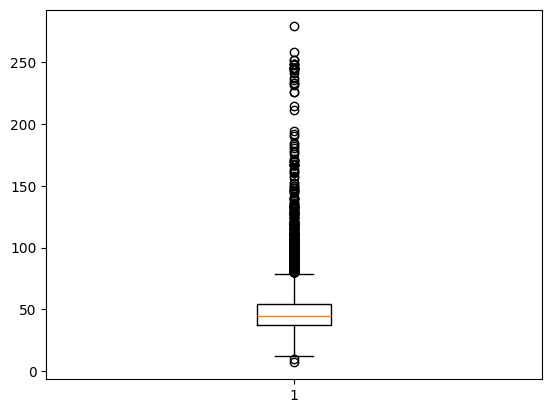

In [86]:
plt.boxplot(data_dsc['length'])

In [87]:
boxplot_length = data_dsc['length'].quantile(0.75) + (data_dsc['length'].quantile(0.75) - data_dsc['length'].quantile(0.25)) * 2.5
boxplot_length

96.5

In [88]:
data_dsc = data_dsc[data_dsc['length'] < boxplot_length]
data_dsc

,IC50,SMILES,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,...,3_cnt,H_cnt,S_cnt,4_cnt,L_cnt,F_cnt,CC_cnt,CCC_cnt,C1_cnt,CN_cnt
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,24,7,9,4,6,10,7,138,...,0,4,0,0,0,0,2,0,2,0
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,21,4,6,4,3,6,7,120,...,0,3,0,0,0,0,2,0,2,0
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,21,3,6,5,2,6,7,118,...,0,3,0,0,0,0,3,0,2,0
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,20,3,6,5,2,6,6,114,...,0,3,0,0,0,0,3,0,2,0
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,24,4,9,6,4,9,3,122,...,2,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34687,2.450000,CC(C)c(cc1)cc(c1[C@@]23C)CC[C@@H]2[C@](C)(CN)CCC3,21,2,1,1,1,1,2,116,...,2,1,0,0,0,0,3,1,0,1
34688,0.740500,OCCNCCNc1ccc(NCCNCCO)c(c12)C(=O)c3c(C2=O)c(O)c...,32,8,10,10,8,10,12,172,...,2,0,0,0,0,0,4,0,0,3
34689,0.003695,CCN(CC)C(=O)[C@@H](NC(=O)C)[C@H]([C@H](C1)N=C(...,24,6,9,4,4,9,7,136,...,0,4,0,0,0,0,2,0,1,1
34690,6.156000,Cc1ccc(cc1)S(=O)(=O)N[C@@H](c2ccccc2)C(=O)Oc(c...,36,1,7,6,1,11,6,186,...,2,1,1,2,0,3,0,0,0,0


In [23]:
data_dsc = data_dsc.fillna(-1)

-------

# Здесь была попытка свести задачу к классификации

In [49]:
quantiles = []
for i in range(0, 101, 50):
    quantiles += [data_dsc['IC50'].quantile(i / 100)]

def get_class(x):
    for i in range(len(quantiles)):
        if x < quantiles[i]:
            return i

data_dsc['class'] = data_dsc['IC50'].apply(lambda x: get_class(x))

In [55]:
data_dsc['class'].nunique()

2

In [54]:
quantiles

[9.97e-06, 3.498, 12.221]

([<matplotlib.axis.XTick at 0x33e97ba00>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

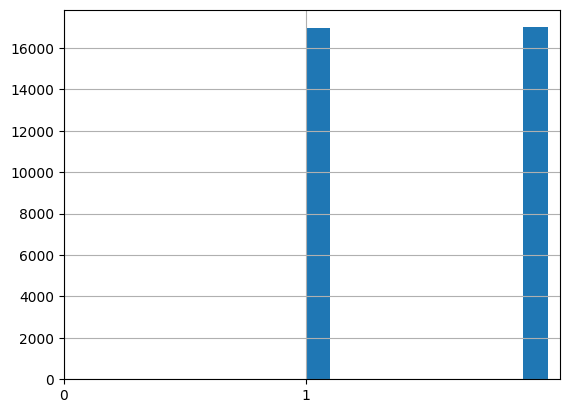

In [56]:
import matplotlib.pyplot as plt

data_dsc['class'].hist()
plt.xticks([i for i in range(data_dsc['class'].nunique())])

In [57]:
data_dsc['class'] = data_dsc['class'].fillna(max(data_dsc['class'])).astype('int') - 1

In [58]:
data_dsc['class'].value_counts()

1    17001
0    16985
Name: class, dtype: int64

In [56]:
data_dsc['IC50'].max(), data_dsc['IC50_log'].max()

(3183.6, 8.066081971422326)

--------

# MOLVEC

### Использование библиотеки MOLVEC для получения эмбеддингов, признаков

In [66]:
!pip3 install git+https://github.com/EBjerrum/molvecgen

  Cloning https://github.com/EBjerrum/molvecgen to /private/var/folders/zg/4scz2l1x7f13kl3dkr2812840000gn/T/pip-req-build-hoaex8l4
  Running command git clone --filter=blob:none --quiet https://github.com/EBjerrum/molvecgen /private/var/folders/zg/4scz2l1x7f13kl3dkr2812840000gn/T/pip-req-build-hoaex8l4
  Resolved https://github.com/EBjerrum/molvecgen to commit f81d5aade18bea60882f5845877f6283366bbe91
  Preparing metadata (setup.py) ... done
  Created wheel for molvecgen: filename=molvecgen-0.1-py3-none-any.whl size=11356 sha256=3abbf81f06ac9dfd6a91cfdee91cd99ed68ec77405a109750b3b31c5eb07a755
  Stored in directory: /private/var/folders/zg/4scz2l1x7f13kl3dkr2812840000gn/T/pip-ephem-wheel-cache-a2wul0wx/wheels/6c/49/c9/6a7c7f7987b50646463dc0e0b06c8fb68f01f061fa313d3325
Successfully built molvecgen


In [89]:
from molvecgen import SmilesVectorizer

In [90]:
smiles = data_dsc['SMILES']
mols = [Chem.MolFromSmiles(smile) for smile in smiles]

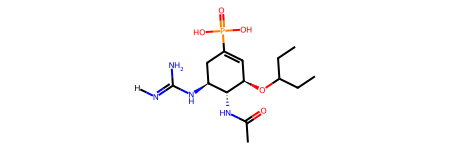

In [91]:
mols[0]

/@e]i+23-[1OcFs=(.)#lZ\NISC5nr7B8P9o64H^$?

In [92]:
sm_en = SmilesVectorizer(canonical = True, augment = False)

print("Default Charset %s"%sm_en.charset)
print("Default Maximum allowed SMILES length %s"%sm_en.maxlength)

sm_en.fit(mols, extra_chars = ["\\"])
print()
print("After fitting")
print("Charset after fit %s"%sm_en.charset)
print("Maximum allowed SMILES length %s"%sm_en.maxlength)

Default Charset @C)(=cOn1S2/H[N]\^$?
Default Maximum allowed SMILES length 120

After fitting
Charset after fit a7H3)S@+.NO5F-s41#I]r\Z2e[P6Biconl(/C=^$?
Maximum allowed SMILES length 100


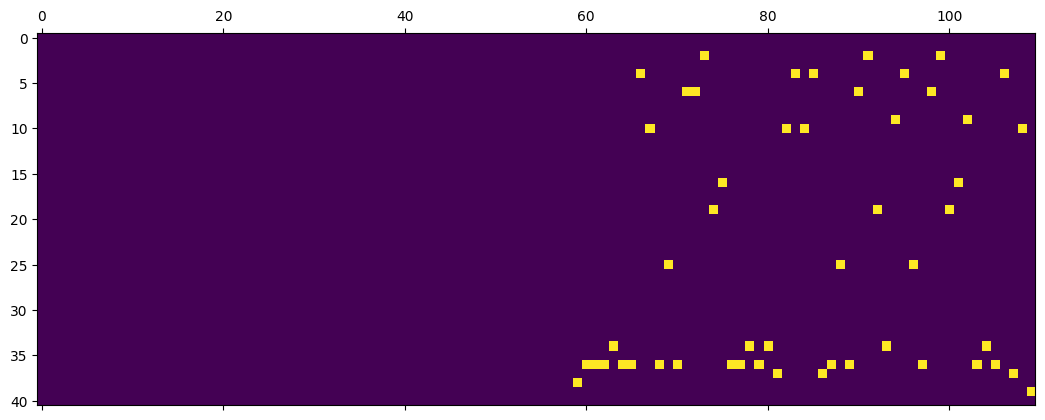

In [93]:
mol_vects = sm_en.transform(mols)
plt.matshow(mol_vects[1].T)

In [94]:
mol_vects.shape

(34445, 110, 41)

In [95]:
sm_en.reverse_transform(mol_vects[0:2])

array(['[H]/N=C(\\N)N[C@H]1CC(P(=O)(O)O)=C[C@@H](OC(CC)CC)[C@@H]1NC(C)=O',
       'CCC(CC)OC[C@@H]1CC(C(=O)O)=C[C@H](N)[C@H]1NC(C)=O'], dtype='<U63')

In [96]:
mol_vects_flat = np.array([arr.flatten() for arr in mol_vects])
mol_vects_2d = np.vstack(mol_vects_flat)
mol_vects_2d.shape

(34445, 4510)

In [97]:
cnt_1 = []
cnt_ind = []
for i in range(len(mol_vects_2d)):
    cur_ind = 0
    cur = []
    s = (mol_vects_2d[i] == 1)
    for j in range(len(s)):
        if s[j]:
            cur_ind += 1
            cur += [j]
    cnt_1 += [cur_ind]
    cnt_ind += [cur + [-1] * (265 - len(cur))] 

In [98]:
data_dsc['cnt_True_molvec'] = cnt_1
data_dsc['ind_True_molvec'] = cnt_ind
data_dsc['emb_molvec'] = mol_vects_2d.tolist()

In [99]:
data_dsc[['length', 'cnt_True_molvec', 'ind_True_molvec', 'emb_molvec']]

,length,cnt_True_molvec,ind_True_molvec,emb_molvec
0,66,65,"[1883, 1911, 1929, 1987, 2044, 2059, 2128, 216...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,52,51,"[2457, 2496, 2537, 2578, 2617, 2660, 2701, 271...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,55,56,"[2252, 2291, 2333, 2373, 2414, 2453, 2497, 251...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,53,53,"[2375, 2414, 2455, 2496, 2535, 2578, 2619, 262...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,55,55,"[2293, 2332, 2367, 2394, 2449, 2490, 2535, 255...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
34687,49,49,"[2539, 2578, 2619, 2658, 2701, 2710, 2777, 280...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
34688,50,52,"[2416, 2429, 2497, 2537, 2558, 2613, 2647, 269...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
34689,63,65,"[1883, 1922, 1963, 1977, 2043, 2086, 2127, 213...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
34690,73,72,"[1596, 1635, 1670, 1697, 1752, 1793, 1834, 187...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [100]:
from molvecgen.vectorizers import MorganDictVectorizer

mdv = MorganDictVectorizer()

In [102]:
#Fit analyses the dataset and set the keys mapping
mdv.fit(mols[0:1])
print(mdv.keys)
mdv.dims

[  31913717   68511885  199163361  246829648  411967733  649201019
  659615979  847957139  847961216  849275503  864662311  864674487
  864942730  984189120 1250928372 1506563592 1510328189 1592347846
 1661986706 1693331843 1745120617 1767111310 1776049442 1824088295
 1852431676 1882418820 1955332226 2192318254 2235918822 2245273601
 2245384272 2246699815 2246728737 2250373459 2438720939 2446961558
 2584514126 2591432844 2901389229 2968968094 2976033787 3032384925
 3148713667 3217380708 3218693969 3259246484 3348579210 3542456614
 3545365497 3767263318 3927890045 4277593716]


52

In [103]:
mdv.transform_mol(mols[0],misses=True)

(array([1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 2., 1., 2., 1., 1., 2., 1.,
        1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2., 2., 3., 2.,
        1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.,
        1.]),
 0)

In [104]:
arr = mdv.transform(mols, misses = False)
arr.shape

In [106]:
data_dsc['mdv'] = arr.tolist()

In [108]:
from molvecgen.vectorizers import HashedMorganVectorizer

hmv = HashedMorganVectorizer(nBits=200)
arr = hmv.transform(mols)
arr.shape

In [110]:
data_dsc['hmv'] = arr.tolist()

In [111]:
from molvecgen.vectorizers import HashedAPVectorizer
hmv = HashedAPVectorizer(nBits=100, augment=True, minLength=4, maxLength=8)
arr = hmv.transform(mols)
arr.shape

(34445, 100)

In [112]:
data_dsc['hmv2'] = arr.tolist()

-------------

# Model

In [113]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

### Также попробуем предсказывать логарифм

In [114]:
data_dsc['IC50_log'] = np.log1p(data_dsc['IC50']) 

In [139]:
data_dsc['IC50_log'].std()

0.6254609872523929

In [144]:
# 'emb_molvec', 'ind_True_molvec', 'hmv', 'hmv2', 'mdv', 'SMILES', 'class', 'Unnamed: 0
# X_train, X_test, y_train, y_test = train_test_split(data_dsc.drop(['IC50', 'SMILES', 'ind_True_molvec', 'hmv', 'hmv2', 'mdv', 'emb_molvec'], axis = 1), data_dsc['IC50'], test_size = 0.2, random_state = 42, shuffle = True)
X_train, X_test, y_train, y_test = train_test_split(data_dsc.drop(['IC50', 'SMILES', 'emb_molvec', 'ind_True_molvec', 'IC50_log'], axis = 1), data_dsc['IC50_log'], test_size = 0.2, random_state = 42, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [135]:
model = CatBoostRegressor(iterations = 4000,
                          verbose = 100,
                          learning_rate = 0.01,
                          max_depth = 9,
                          loss_function = 'RMSE',
                          eval_metric = 'R2')

model.fit(X_train, y_train, eval_set = (X_val, y_val), embedding_features = ['hmv', 'hmv2', 'mdv'])
# model.fit(X_train, y_train, eval_set = (X_val, y_val))
preds_class = model.predict(X_test)
print(f'MSE: {mse(y_test, preds_class)}')
print(f'MAE: {mae(y_test, preds_class)}')
print(f'RMSE: {mse(y_test, preds_class, squared = False)}')

0:	learn: 0.0031679	test: 0.0030212	best: 0.0030212 (0)	total: 9.32ms	remaining: 37.3s
100:	learn: 0.1621046	test: 0.1464617	best: 0.1464617 (100)	total: 656ms	remaining: 25.3s
200:	learn: 0.2059971	test: 0.1755915	best: 0.1755915 (200)	total: 1.3s	remaining: 24.5s
300:	learn: 0.2287753	test: 0.1840393	best: 0.1840393 (300)	total: 1.94s	remaining: 23.8s
400:	learn: 0.2451460	test: 0.1876914	best: 0.1876914 (400)	total: 2.57s	remaining: 23s
500:	learn: 0.2581235	test: 0.1897541	best: 0.1897551 (499)	total: 3.19s	remaining: 22.3s
600:	learn: 0.2693475	test: 0.1911049	best: 0.1911084 (599)	total: 3.82s	remaining: 21.6s
700:	learn: 0.2791980	test: 0.1922152	best: 0.1922533 (693)	total: 4.44s	remaining: 20.9s
800:	learn: 0.2888845	test: 0.1928433	best: 0.1930115 (792)	total: 5.05s	remaining: 20.2s
900:	learn: 0.2982083	test: 0.1937232	best: 0.1937496 (897)	total: 5.67s	remaining: 19.5s
1000:	learn: 0.3076762	test: 0.1946896	best: 0.1946896 (1000)	total: 6.29s	remaining: 18.8s
1100:	learn: 0

In [140]:
print(f'MSE: {mse(y_test, preds_class)}')
print(f'MAE: {mae(y_test, preds_class)}')
print(f'RMSE: {mse(y_test, preds_class, squared = False)}')
print(f'R2-score: {r2_score(y_test, preds_class)}')

MSE: 5.60655483281179
MAE: 1.8489852101010347
RMSE: 2.3678164694105392
R2-score: 0.19962471971404427


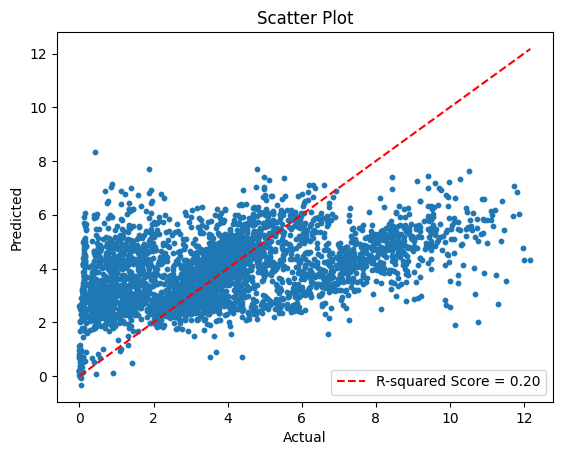

In [141]:
plt.figure(3)
t_true, t_pred = y_test, preds_class
plt.scatter(t_true, t_pred, s=10)
plt.plot([t_true.min(), t_true.max()], [t_true.min(), t_true.max()], color='red', label='R-squared Score = %0.2f' % r2_score(t_true, t_pred), linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot')
plt.legend(loc='lower right')

### Продолжим идею, представленную в начале. Как выяснилось ранее, стандартное отклонение у таргета = 3. Посчитаем, какая доля от предиктов отличалась от реального таргета меньше, чем на 2 * std

In [143]:
acc = 0
for i in range(len(preds_class)):
    if abs(preds_class[i] - y_test.values[i]) <= 3:
        acc += 1
print(acc / len(y_test))

0.7692307692307693


# Предсказания логарифма таргета

In [145]:
model = CatBoostRegressor(iterations = 4000,
                          verbose = 100,
                          learning_rate = 0.01,
                          max_depth = 9,
                          loss_function = 'RMSE',
                          eval_metric = 'R2')

model.fit(X_train, y_train, eval_set = (X_val, y_val), embedding_features = ['hmv', 'hmv2', 'mdv'])
# model.fit(X_train, y_train, eval_set = (X_val, y_val))
preds_class = model.predict(X_test)
print(f'MSE: {mse(y_test, preds_class)}')
print(f'MAE: {mae(y_test, preds_class)}')
print(f'RMSE: {mse(y_test, preds_class, squared = False)}')

0:	learn: 0.0030275	test: 0.0029408	best: 0.0029408 (0)	total: 8.96ms	remaining: 35.8s
100:	learn: 0.1599939	test: 0.1432370	best: 0.1432370 (100)	total: 653ms	remaining: 25.2s
200:	learn: 0.2043624	test: 0.1738110	best: 0.1738110 (200)	total: 1.31s	remaining: 24.8s
300:	learn: 0.2271011	test: 0.1828274	best: 0.1828274 (300)	total: 1.97s	remaining: 24.3s
400:	learn: 0.2423010	test: 0.1861847	best: 0.1861847 (400)	total: 2.64s	remaining: 23.7s
500:	learn: 0.2543228	test: 0.1884971	best: 0.1884971 (500)	total: 3.3s	remaining: 23.1s
600:	learn: 0.2640882	test: 0.1900655	best: 0.1900871 (599)	total: 3.94s	remaining: 22.3s
700:	learn: 0.2726076	test: 0.1911443	best: 0.1911464 (698)	total: 4.6s	remaining: 21.6s
800:	learn: 0.2815605	test: 0.1921078	best: 0.1921285 (799)	total: 5.27s	remaining: 21.1s
900:	learn: 0.2907093	test: 0.1933029	best: 0.1933083 (899)	total: 5.91s	remaining: 20.3s
1000:	learn: 0.3000334	test: 0.1945344	best: 0.1945428 (999)	total: 6.55s	remaining: 19.6s
1100:	learn: 0

In [146]:
print(f'MSE: {mse(y_test, preds_class)}')
print(f'MAE: {mae(y_test, preds_class)}')
print(f'RMSE: {mse(y_test, preds_class, squared = False)}')
print(f'R2-score: {r2_score(y_test, preds_class)}')

MSE: 0.3045278878816163
MAE: 0.4361453471420301
RMSE: 0.5518404550969567
R2-score: 0.20355839035748768


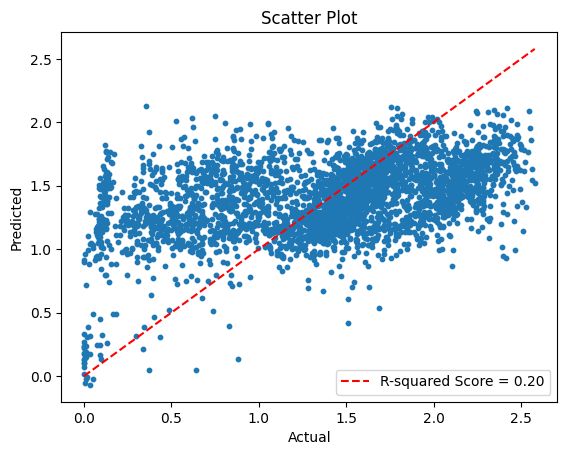

In [147]:
plt.figure(3)
t_true, t_pred = y_test, preds_class
plt.scatter(t_true, t_pred, s=10)
plt.plot([t_true.min(), t_true.max()], [t_true.min(), t_true.max()], color='red', label='R-squared Score = %0.2f' % r2_score(t_true, t_pred), linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot')
plt.legend(loc='lower right')

In [149]:
data_dsc['IC50_log'].std()

0.6254609872523929

In [151]:
acc = 0
for i in range(len(preds_class)):
    if abs(preds_class[i] - y_test.values[i]) <= data_dsc['IC50_log'].std():
        acc += 1
print(acc / len(y_test))

0.7152394775036285


### Какая доля отличается менее, чем на std

In [152]:
acc = 0
for i in range(len(preds_class)):
    if abs(preds_class[i] - y_test.values[i]) <= data_dsc['IC50_log'].std() / 2:
        acc += 1
print(acc / len(y_test))

0.4548621190130624


### Важность признаков (когда в фичах есть эмбеддинги, не работает)

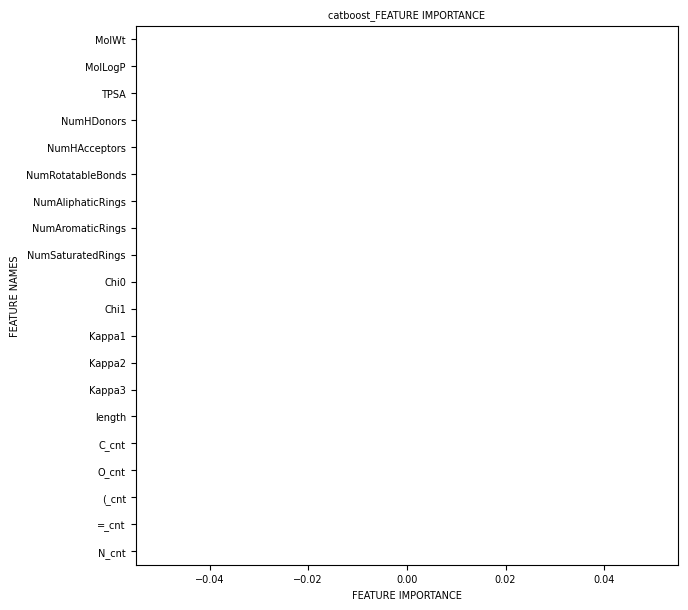

In [160]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_color_codes("muted")

def plot_feature_importance(importance,names,model_type, top = 50):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    # plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:top], y=fi_df['feature_names'][:top], palette = "husl")
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    return fi_df

plt.figure(figsize=(7, 7))
sns.set_context(rc={"font.size":7,"axes.titlesize":7,"axes.labelsize":7})
fdf = plot_feature_importance(model.feature_importances_, X_train.columns, 'catboost_', 20)

## Пробуем другую модель

In [170]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [197]:
model = LinearRegression().fit(X_train, y_train)
preds_class = model.predict(X_test)
print(f'MSE: {mse(y_test, preds_class)}')
print(f'MAE: {mae(y_test, preds_class)}')
print(f'RMSE: {mse(y_test, preds_class, squared = False)}')
print(f'R2-score: {r2_score(y_test, preds_class)}')

MSE: 5.891777141837134
MAE: 1.9071993609040003
RMSE: 2.427298321557763
R2-score: 0.15321157332283974


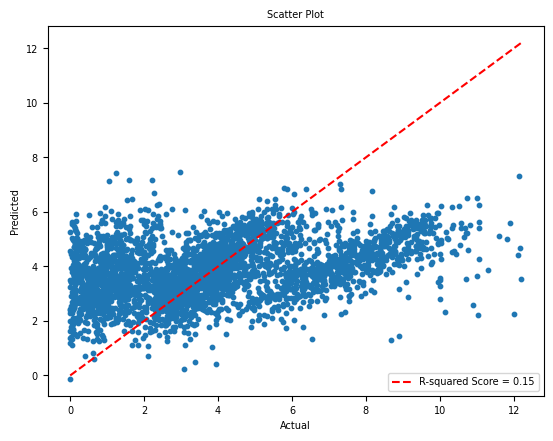

In [198]:
plt.figure(3)
t_true, t_pred = y_test, preds_class
plt.scatter(t_true, t_pred, s=10)
plt.plot([t_true.min(), t_true.max()], [t_true.min(), t_true.max()], color='red', label='R-squared Score = %0.2f' % r2_score(t_true, t_pred), linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot')
plt.legend(loc='lower right')

## Модель классификации на два класса по медиане

In [59]:
X_train, X_test, y_train, y_test = train_test_split(data_dsc.drop(['IC50', 'SMILES', 'class', 'emb_molvec', 'ind_True_molvec', 'hmv', 'hmv2', 'mdv'], axis = 1), data_dsc['class'], test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [62]:
model = CatBoostClassifier(iterations = 3000,
                           verbose = 500,
                        #    l2_leaf_reg = 1e-1,
                           loss_function = 'CrossEntropy',
                           eval_metric = 'F1')

model.fit(X_train, y_train, eval_set = (X_val, y_val))
preds_class = model.predict(X_test)
print('F1: ', f1_score(y_test, preds_class, average = 'macro'))
print(f'accuracy: {accuracy_score(y_test, preds_class)}')

0:	learn: 0.6944678	test: 0.7001357	best: 0.7001357 (0)	total: 7.17ms	remaining: 21.5s
500:	learn: 0.7215329	test: 0.7112479	best: 0.7142462 (16)	total: 2.35s	remaining: 11.7s
1000:	learn: 0.7502312	test: 0.7158899	best: 0.7175316 (830)	total: 4.55s	remaining: 9.09s
1500:	learn: 0.7713142	test: 0.7136018	best: 0.7175316 (830)	total: 6.84s	remaining: 6.83s
2000:	learn: 0.7919261	test: 0.7139627	best: 0.7175316 (830)	total: 9.13s	remaining: 4.56s
2500:	learn: 0.8113506	test: 0.7100793	best: 0.7175316 (830)	total: 11.3s	remaining: 2.26s
2999:	learn: 0.8297635	test: 0.7064846	best: 0.7175316 (830)	total: 13.6s	remaining: 0us

bestTest = 0.7175315568
bestIteration = 830

Shrink model to first 831 iterations.


NameError: name 'f1_score' is not defined

In [64]:
preds_class = model.predict(X_test)
print('F1: ', f1_score(y_test, preds_class, average = 'macro'))
print(f'accuracy: {accuracy_score(y_test, preds_class)}')

F1:  0.693767867352773
accuracy: 0.6940276551927037


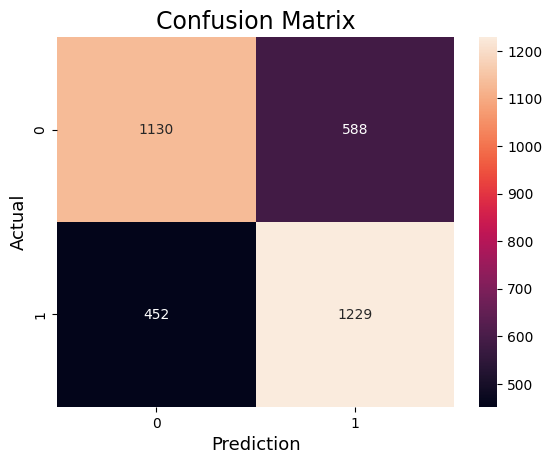

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, preds_class)

sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels = ['0','1'],
            yticklabels = ['0','1'])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [65]:
print(classification_report(y_test, preds_class))

              precision    recall  f1-score   support

           0       0.71      0.66      0.68      1718
           1       0.68      0.73      0.70      1681

    accuracy                           0.69      3399
   macro avg       0.70      0.69      0.69      3399
weighted avg       0.70      0.69      0.69      3399



## Classification report для 20 классов

In [64]:
print(classification_report(y_test, preds_class))

              precision    recall  f1-score   support

           0       0.16      0.26      0.19       166
           1       0.11      0.08      0.09       178
           2       0.05      0.05      0.05       188
           3       0.25      0.01      0.01       181
           4       0.08      0.01      0.01       193
           5       0.05      0.01      0.02       176
           6       0.10      0.06      0.07       164
           7       0.10      0.23      0.14       178
           8       0.08      0.14      0.10       187
           9       0.05      0.04      0.04       170
          10       0.07      0.06      0.06       190
          11       0.11      0.03      0.04       197
          12       0.06      0.03      0.04       188
          13       0.18      0.01      0.02       173
          14       0.00      0.00      0.00       184
          15       0.03      0.01      0.02       171
          16       0.06      0.01      0.02       178
          17       0.08    

------

# DeepIC50

Мы нашли готовое решение для задачи регрессии IC50, написанное на Keras. Переписали на torch

In [371]:
import torch
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(2082, 16, kernel_size = 11, stride = 1, padding = 5)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 16, kernel_size = 11, stride = 1, padding = 5)
        self.bn2 = nn.BatchNorm1d(16)
        self.conv3 = nn.Conv1d(16, 32, kernel_size = 11, stride = 1, padding = 5)
        self.bn3 = nn.BatchNorm1d(32)
        self.conv4 = nn.Conv1d(32, 32, kernel_size = 11, stride = 1, padding = 5)
        self.bn4 = nn.BatchNorm1d(32)
        self.conv5 = nn.Conv1d(32, 64, kernel_size = 11, stride = 1, padding = 5)
        self.bn5 = nn.BatchNorm1d(64)
        self.conv6 = nn.Conv1d(64, 64, kernel_size = 11, stride = 1, padding = 5)
        self.bn6 = nn.BatchNorm1d(64)
        self.fc1 = nn.Linear(64, 1024)
        self.bn7 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.bn8 = nn.BatchNorm1d(2048)
        self.fc3 = nn.Linear(2048, 4096)
        self.bn9 = nn.BatchNorm1d(4096)
        self.fc4 = nn.Linear(4096, 2048)
        self.bn10 = nn.BatchNorm1d(2048)
        self.fc5 = nn.Linear(2048, 1024)
        self.bn11 = nn.BatchNorm1d(1024)
        self.fc6 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool1d(F.relu(self.bn2(self.conv2(x))), 1)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool1d(F.relu(self.bn4(self.conv4(x))), 1)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool1d(F.relu(self.bn6(self.conv6(x))), 1)
        x = x.view(x.size(0), -1) # Flatten layer
        x = F.dropout(F.relu(self.bn7(self.fc1(x))), p = 0.02)
        x = F.dropout(F.relu(self.bn8(self.fc2(x))), p = 0.02)
        x = F.dropout(F.relu(self.bn9(self.fc3(x))), p = 0.02)
        x = F.dropout(F.relu(self.bn10(self.fc4(x))), p = 0.02)
        x = F.dropout(F.relu(self.bn11(self.fc5(x))), p = 0.02)
        x = F.softmax(self.fc6(x), dim=1)
        return x

# Создание экземпляра модели
model = Net(num_classes = 20)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

# Вывод архитектуры модели
print(model)

Net(
  (conv1): Conv1d(2082, 16, kernel_size=(11,), stride=(1,), padding=(5,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 16, kernel_size=(11,), stride=(1,), padding=(5,))
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(16, 32, kernel_size=(11,), stride=(1,), padding=(5,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(32, 32, kernel_size=(11,), stride=(1,), padding=(5,))
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(32, 64, kernel_size=(11,), stride=(1,), padding=(5,))
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,))
  (bn6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features

In [385]:
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(data_dsc.join(Y).drop(['IC50', 'SMILES', 'class'], axis = 1), data_dsc['class'], test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

train_data = TensorDataset(torch.FloatTensor(X_train.values).unsqueeze(2), torch.FloatTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_val.values).unsqueeze(2), torch.FloatTensor(y_val.values))

batch_size = 512

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)

In [373]:
accuracy_train = []
accuracy_valid = []
loss_train = []
loss_valid = []

import copy

def train(n_epoch, optimizer, loss, train_loader, test_loader, ec = 25):
  try:
    best_loss = 283657652956245
    epochs_without_evolution = 0

    for epoch in range(n_epoch):
      accuracy_tr, accuracy_val, loss_tr, loss_v = 0, 0, 0, 0
      model.train()
      for i, (data, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        y_pred = model(data).squeeze(-1) * 0.9
        cur_loss = loss(y_pred, labels.long())
        loss_tr += cur_loss
        cur_accuracy = f1(torch.argmax(y_pred, dim = 1), labels.long(), average='macro')
        accuracy_tr += cur_accuracy

        cur_loss.backward()
        optimizer.step()

      loss_train.append(loss_tr / len(train_loader))
      accuracy_train.append(accuracy_tr / len(train_loader))

      if loss_train[-1] < best_loss:
        best_loss = loss_train[-1]
        best_model = copy.deepcopy(model)
        # epochs_without_evolution = 0
      # else:
      #   epochs_without_evolution += 1
      # if epochs_without_evolution > ec:
      #   print('Улучшения не наблюдались более 25 эпох, прекращаем обучение')
      #   return

      model.eval()
      for i, (data, labels) in enumerate(test_loader):

        with torch.no_grad():
          y_pred = model(data).squeeze(-1) * 0.9

        cur_loss = loss(y_pred, labels.long())
        loss_v += cur_loss
        cur_accuracy = f1(torch.argmax(y_pred, dim = 1), labels.long(), average='macro')
        accuracy_val += cur_accuracy
        # y_pred = y_pred.max(1)[1].detach().cpu().numpy()
        # cur_accuracy = np.mean(labels.cpu().numpy() == y_pred)
        # accuracy_val += cur_accuracy

      loss_valid.append(loss_v / len(test_loader))
      accuracy_valid.append(accuracy_val / len(test_loader))

      print('Train. Epoch [{}/{}], Loss: {:.4f}, F1: {:.4f}'.format(epoch + 1, n_epoch, loss_train[-1], accuracy_train[-1]), 'Valid. Epoch [{}/{}], Loss: {:.4f}, F1: {:.4f}'.format(epoch + 1, n_epoch, loss_valid[-1], accuracy_valid[-1]))
  except KeyboardInterrupt:
    return best_model

In [374]:
best_model_ = train(1000, optimizer, criterion, train_loader, test_loader)

Train. Epoch [1/1000], Loss: 2.9366, F1: 0.0808 Valid. Epoch [1/1000], Loss: 2.9418, F1: 0.0645
Train. Epoch [2/1000], Loss: 2.9206, F1: 0.0908 Valid. Epoch [2/1000], Loss: 2.9293, F1: 0.0844
Train. Epoch [3/1000], Loss: 2.9187, F1: 0.0921 Valid. Epoch [3/1000], Loss: 2.9274, F1: 0.0866
Train. Epoch [4/1000], Loss: 2.9147, F1: 0.0955 Valid. Epoch [4/1000], Loss: 2.9528, F1: 0.0621
Train. Epoch [5/1000], Loss: 2.9144, F1: 0.0962 Valid. Epoch [5/1000], Loss: 2.9257, F1: 0.0880
Train. Epoch [6/1000], Loss: 2.9127, F1: 0.0993 Valid. Epoch [6/1000], Loss: 2.9334, F1: 0.0824
Train. Epoch [7/1000], Loss: 2.9100, F1: 0.1027 Valid. Epoch [7/1000], Loss: 2.9501, F1: 0.0743
Train. Epoch [8/1000], Loss: 2.9115, F1: 0.1015 Valid. Epoch [8/1000], Loss: 2.9243, F1: 0.0966
Train. Epoch [9/1000], Loss: 2.9094, F1: 0.1061 Valid. Epoch [9/1000], Loss: 2.9749, F1: 0.0541
Train. Epoch [10/1000], Loss: 2.9082, F1: 0.1062 Valid. Epoch [10/1000], Loss: 2.9145, F1: 0.1056
Train. Epoch [11/1000], Loss: 2.9045, 

------

# KAN

И в задаче регрессии, и в задаче классификации, KAN показал себя хуже, чем обычная линейная модель. В случае регрессии предсказывает просто константу

In [116]:
import kan
from kan import KAN
import torch
from torch import nn
from torch.nn import functional as F

In [125]:
data_dsc = data_dsc.fillna(-1)

In [169]:
device = 'mps'
model = KAN(width = [49, 10, 1], grid = 5, k = 5, seed = 0, device = device)
# model = KAN(width = [34, 10], grid = 3, k = 3)

X_train, X_test, y_train, y_test = train_test_split(data_dsc.drop(['IC50', 'SMILES'], axis = 1), data_dsc['IC50'], test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

dataset = {}
dataset['train_input'] = torch.FloatTensor(X_train.values).to(device)
dataset['train_label'] = torch.FloatTensor(y_train.values).to(device)
dataset['test_input'] = torch.FloatTensor(X_val.values).to(device)
dataset['test_label'] = torch.FloatTensor(y_val.values).to(device)

# def train_acc():
#     return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

# def test_acc():
#     return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

# results = model.train(dataset, opt="LBFGS", steps=20, metrics = (train_acc, test_acc), loss_fn = torch.nn.CrossEntropyLoss())
results = model.train(dataset, opt = "Adam", steps = 10, loss_fn = torch.nn.MSELoss(), device = 'mps')

train loss: 4.67e+00 | test loss: nan | reg: nan :  10%|█▎           | 1/10 [00:21<03:09, 21.06s/it]


RuntimeError: MPS backend out of memory (MPS allocated: 14.47 GB, other allocations: 958.38 MB, max allowed: 18.13 GB). Tried to allocate 2.75 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [152]:
torch.FloatTensor(X_val.values).shape, torch.FloatTensor(X_test.values).shape

(torch.Size([3399, 49]), torch.Size([3399, 49]))

In [79]:
print(classification_report(torch.FloatTensor(y_test.values).long(), model(torch.FloatTensor(X_test.values)).argmax(dim = 1)))

              precision    recall  f1-score   support

           0       0.21      0.22      0.21       344
           1       0.11      0.10      0.11       369
           2       0.08      0.07      0.07       369
           3       0.19      0.33      0.24       342
           4       0.18      0.20      0.19       357
           5       0.17      0.11      0.13       387
           6       0.14      0.10      0.11       361
           7       0.08      0.09      0.09       355
           8       0.20      0.18      0.19       361
           9       0.26      0.30      0.28       379

    accuracy                           0.17      3624
   macro avg       0.16      0.17      0.16      3624
weighted avg       0.16      0.17      0.16      3624



In [80]:
accuracy_score(model(torch.FloatTensor(X_val.values)).argmax(dim = 1), torch.FloatTensor(y_val.values).long()), accuracy_score(model(torch.FloatTensor(X_test.values)).argmax(dim = 1), torch.FloatTensor(y_test.values).long())

(0.17609715705216672, 0.1672185430463576)

In [135]:
mse(model(torch.FloatTensor(X_val.values)).detach().numpy(), torch.FloatTensor(y_val.values).long()), mse(model(torch.FloatTensor(X_test.values)).detach().numpy(), torch.FloatTensor(y_test.values).long())

(22447.769582576762, 22167.512929406344)

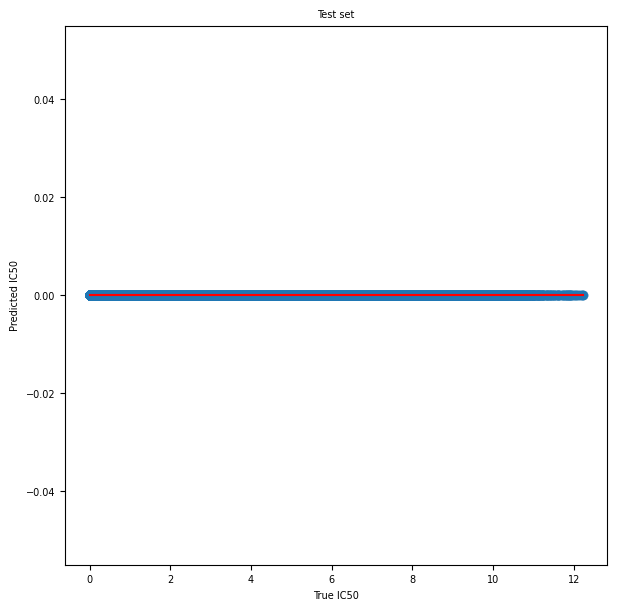

In [168]:
plt.figure(figsize = (7, 7))
pr = model(torch.FloatTensor(X_train.values).to(device)).detach().cpu().numpy()
plt.scatter(y_train, pr, alpha = 0.5)
plt.plot([0, y_train.max()], [0, pr.max()], color = "red")
plt.xlabel("True IC50")
plt.ylabel("Predicted IC50")
plt.title("Test set")
plt.show()

In [108]:
mae(np.exp(model(torch.FloatTensor(X_val.values)).detach().numpy()), np.exp(torch.FloatTensor(y_val.values).long())), mae(np.exp(model(torch.FloatTensor(X_test.values)).detach().numpy()), np.exp(torch.FloatTensor(y_test.values).long()))

(4.656586318053359, 4.901777707362826)